In [1]:
%load_ext autoreload
%autoreload 2

from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

from root_pandas import read_root

Welcome to JupyROOT 6.10/04


In [2]:
import ROOT

In [3]:
plt.rcParams.update({'font.size': 18})

In [4]:
dfDATA = read_root('/home/david/data/MCC9/November/MuCS/MuCSTrackTagger_ana_DATA_v2.root', key="MuCSTrackTaggerpandora/tree")
print(dfDATA.shape)

(93979, 27)


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [5]:
dfMCC9 = read_root('/home/david/data/MCC9/November/MuCS/MuCSTrackTagger_ana_MC_v2.root', key="MuCSTrackTaggerpandora/tree")
print(dfMCC9.shape)

(21000, 27)


In [6]:
print dfDATA.keys()

Index([u'_run', u'_sub', u'_evt', u'_ntag', u'_trk_len', u'_trk_start_x',
       u'_trk_start_y', u'_trk_start_z', u'_trk_end_x', u'_trk_end_y',
       u'_trk_end_z', u'_trk_dir_x', u'_trk_dir_y', u'_trk_dir_z', u'_trk_x_v',
       u'_trk_y_v', u'_trk_z_v', u'_nflash', u'_flash_pe', u'_flash_t',
       u'_flash_z', u'_flash_y', u'_flash_zw', u'_flash_yw', u'_gain_v',
       u'_flash_pe_v', u'_flash_pe_v_corr'],
      dtype='object')


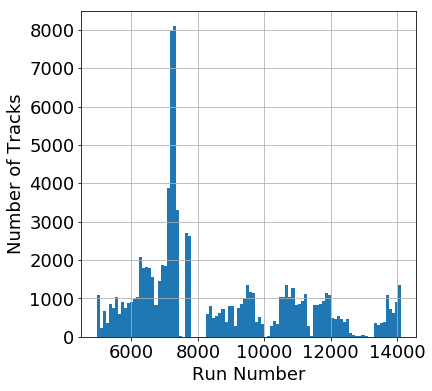

In [7]:
fig = plt.figure(figsize=(6,6))
plt.hist(dfDATA['_run'].values,bins=100)
plt.grid()
plt.xlabel('Run Number')
plt.ylabel('Number of Tracks')
plt.show()

In [8]:
trk_strt_x = dfDATA['_trk_start_x'].values
trk_strt_y = dfDATA['_trk_start_y'].values
trk_strt_z = dfDATA['_trk_start_z'].values
trk_end_x = dfDATA['_trk_end_x'].values
trk_end_y = dfDATA['_trk_end_y'].values
trk_end_z = dfDATA['_trk_end_z'].values

trk_strtm_x = dfMCC9['_trk_start_x'].values
trk_strtm_y = dfMCC9['_trk_start_y'].values
trk_strtm_z = dfMCC9['_trk_start_z'].values
trk_endm_x = dfMCC9['_trk_end_x'].values
trk_endm_y = dfMCC9['_trk_end_y'].values
trk_endm_z = dfMCC9['_trk_end_z'].values

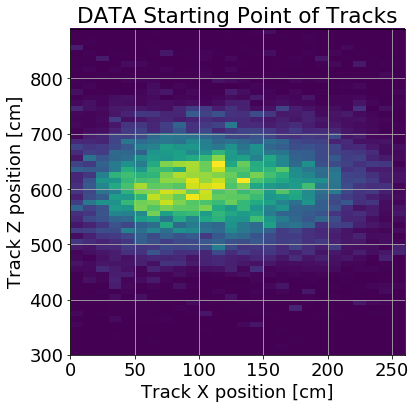

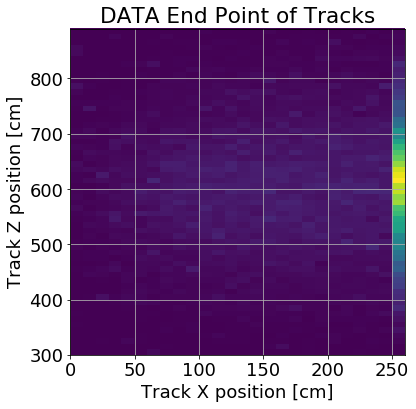

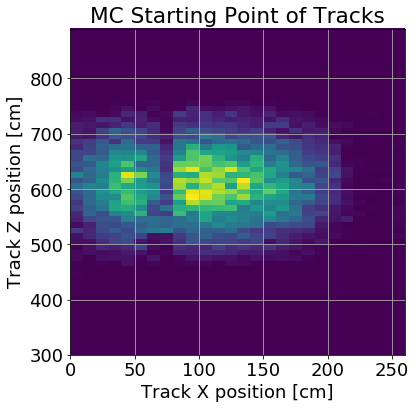

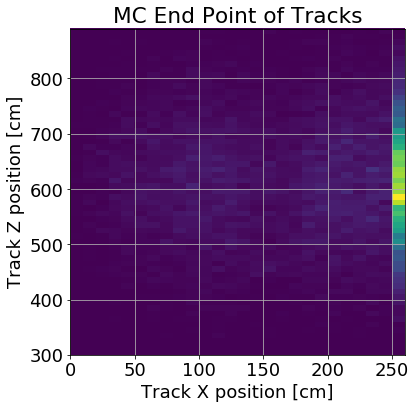

In [9]:
BINX = np.arange(0,270,10)
BINY = np.arange(-116,116,10)
BINZ = np.arange(300,900,10)
fig = plt.figure(figsize=(6,6))
plt.hist2d(trk_strt_x,trk_strt_z,bins=(BINX,BINZ))
plt.grid()
plt.title('DATA Starting Point of Tracks')
plt.xlabel('Track X position [cm]')
plt.ylabel('Track Z position [cm]')
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist2d(trk_end_x,trk_end_z,bins=(BINX,BINZ))
plt.grid()
plt.title('DATA End Point of Tracks')
plt.xlabel('Track X position [cm]')
plt.ylabel('Track Z position [cm]')
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist2d(trk_strtm_x,trk_strtm_z,bins=(BINX,BINZ))
plt.grid()
plt.title('MC Starting Point of Tracks')
plt.xlabel('Track X position [cm]')
plt.ylabel('Track Z position [cm]')
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist2d(trk_endm_x,trk_endm_z,bins=(BINX,BINZ))
plt.grid()
plt.title('MC End Point of Tracks')
plt.xlabel('Track X position [cm]')
plt.ylabel('Track Z position [cm]')
plt.show()

In [10]:
dfDATA['pecm'] = dfDATA['_flash_pe'] / dfDATA['_trk_len']
dfMCC9['pecm'] = dfMCC9['_flash_pe'] / dfMCC9['_trk_len']

In [11]:
def PEsum(x):
    pe_v = x['_flash_pe_v']
    return np.sum(pe_v)
def PEsumGain(x):
    pe_v = x['_flash_pe_v']
    gain_v = x['_gain_v']
    petot = 0.
    for i,g in enumerate(gain_v):
        if ((i%100) < 32):
            petot += pe_v[i] * (20.  / g)
    return petot

In [12]:
dfDATA['pesum'] = dfDATA.apply(lambda x : PEsum(x), axis=1)
dfDATA['pesumgain'] = dfDATA.apply(lambda x : PEsumGain(x), axis=1)

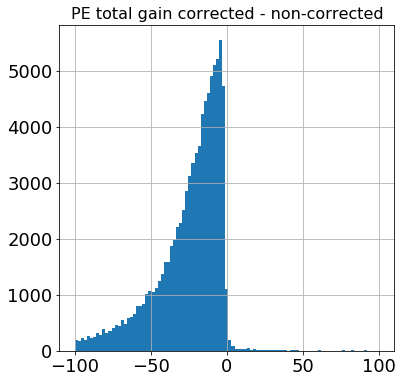

In [13]:
pediff = dfDATA['pesumgain'].values - dfDATA['pesum'].values
fig = plt.figure(figsize=(6,6))
plt.hist(pediff,bins=np.linspace(-100,100,100))
plt.grid()
plt.title('PE total gain corrected - non-corrected',fontsize=16)
plt.show()

In [14]:
dfDATA['pecmg'] = dfDATA['pesumgain'] / dfDATA['_trk_len']
dfMCC9['pecmg'] = dfMCC9['pecm']

In [15]:
# only use data where gains are computed
dfDATA = dfDATA.query('_run < 10000')

In [16]:
def TruncMean(v,iteration):
    median = np.median(v)
    sigma  = np.std(v)
    vnew = []
    for e in v:
        if ((e > (median-2*sigma)) and (e < (median+2*sigma))):
            vnew.append(e)
    print iteration
    newmedian = np.median(vnew)
    if (len(vnew) < 100):
        print 'too short!'
        return newmedian
    if (np.abs(median-newmedian)/median < 0.05):
        print 'converged!'
        return newmedian
    if (iteration > 10):
        print 'too many iterations!'
        return newmedian
    return TruncMean(vnew,iteration+1)

In [17]:
# list of bins to use in X
start_bin_v = np.linspace(20,180,15)

# calculate ratio of PE/cm from two different DataFrames in bins of track X
# varname is the variable to cut on for PE/cm (can be with or without gain correction, hence an argument)
def Ratio(DF1,DF2,varname):
    
    # containers to store measured values for each slice in X
    xpos_avg_v  = []
    
    median_pecm_DF1 = []
    error_pecm_DF1  = []
    
    median_pecm_DF2 = []
    error_pecm_DF2  = []
    
    frac_v = []
    frac_e = []
    
    for n in xrange(len(start_bin_v)-1):
        
        xposmin = start_bin_v[n]
        xposmax = start_bin_v[n+1]
        xpos_avg_v.append( (xposmin+xposmax)/2. )
        
        # require track start point fall in the current bin in X and cut out tails of PE/cm
        DF1_sub = DF1.query('_trk_start_x > %i and _trk_start_x < %i and %s > 0 and %s < 10.'%(xposmin,xposmax,varname,varname))
        DF2_sub = DF2.query('_trk_start_x > %i and _trk_start_x < %i and %s > 0 and %s < 10.'%(xposmin,xposmax,varname,varname))
 
    
        v1 = DF1_sub[varname].values
        # compute truncated mean of distribution -> this will be the quantitative representation
        # of the PE/cm measured at a given bin.
        pecm1 = TruncMean(v1,0)
        err1  = np.std(v1) / np.sqrt( len(v1) )
        median_pecm_DF1.append(pecm1)
        error_pecm_DF1.append(err1)
        
        # do the same for the second DataFrame
        v2 = DF2_sub[varname].values
        pecm2 = TruncMean(v2,0)
        err2  = np.std(v2) / np.sqrt( len(v2) )
        median_pecm_DF2.append(pecm2)
        error_pecm_DF2.append(err2)
        
        # optional:
        # plot the distribution of PE/cm for this slice in X and the measured truncated mean
        PECMbins = np.linspace(0,np.max(np.array([pecm1,pecm2]))*3,20)
        fig = plt.figure(figsize=(4,4))
        plt.hist(v1,bins=PECMbins,label='DF1',histtype='step',lw=2,color='b')
        plt.axvline(pecm1,color='b',lw=2)
        plt.hist(v2,bins=PECMbins,label='DF2',histtype='step',lw=2,color='r')
        plt.axvline(pecm2,color='r',lw=2)
        plt.xlabel('PE / cm')
        plt.title('Track start X [%i, %i]'%(xposmin,xposmax))
        plt.grid()
        plt.show()
        
        # keep track of the ratio PE/cm between the two data-frames
        frac_v.append(pecm1/pecm2)
        frac_e.append( (pecm1/pecm2)* np.sqrt( (err1/pecm1)**2 + (err2/pecm2)**2 ) )
        
    return [xpos_avg_v,[median_pecm_DF1,error_pecm_DF1],[median_pecm_DF2,error_pecm_DF2],[frac_v,frac_e]]

0
converged!
0
converged!


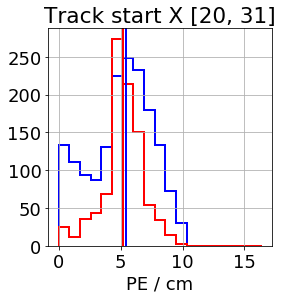

0
converged!
0
converged!


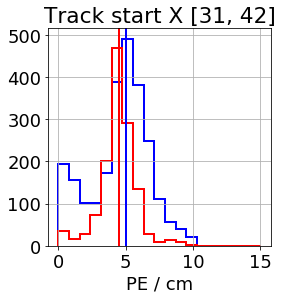

0
converged!
0
converged!


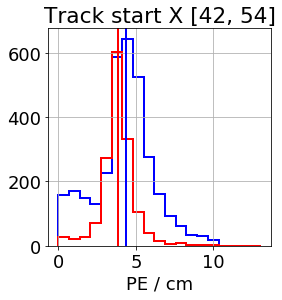

0
converged!
0
converged!


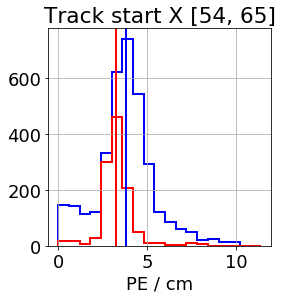

0
converged!
0
converged!


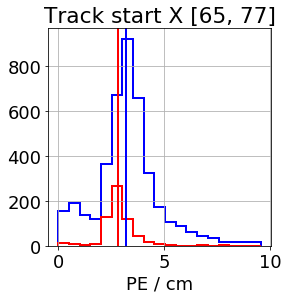

0
converged!
0
converged!


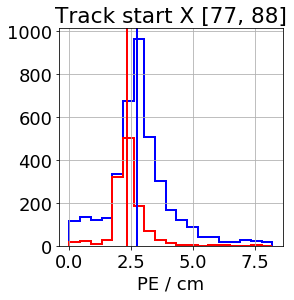

0
converged!
0
converged!


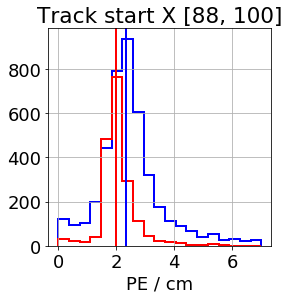

0
converged!
0
converged!


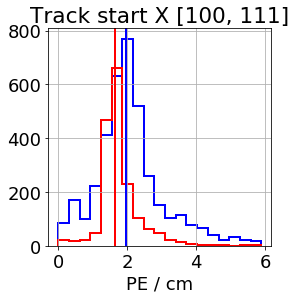

0
converged!
0
converged!


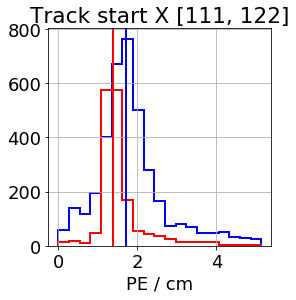

0
converged!
0
converged!


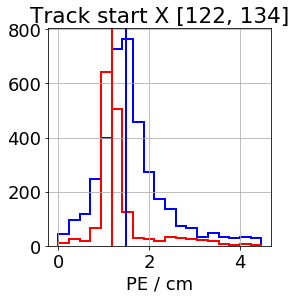

0
converged!
0
converged!


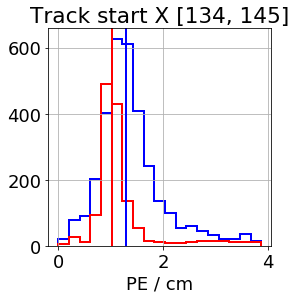

0
converged!
0
converged!


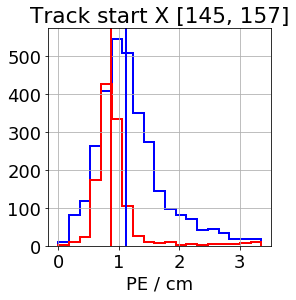

0
converged!
0
converged!


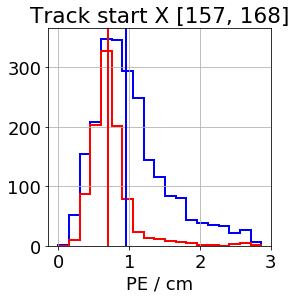

0
1
2
converged!
0
converged!


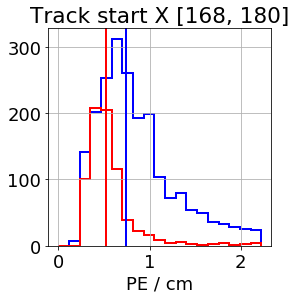

0
converged!
0
converged!


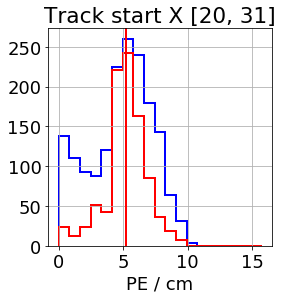

0
converged!
0
converged!


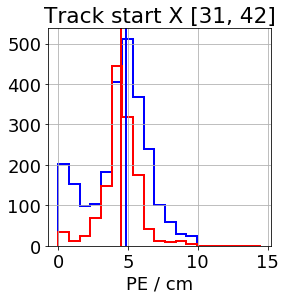

0
converged!
0
converged!


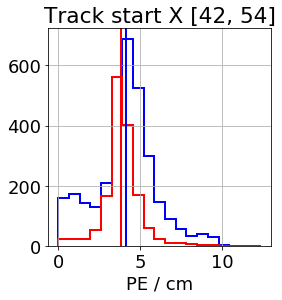

0
converged!
0
converged!


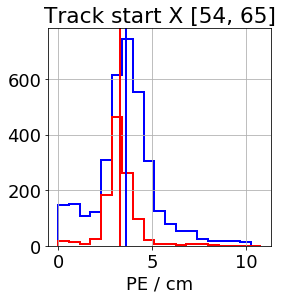

0
converged!
0
converged!


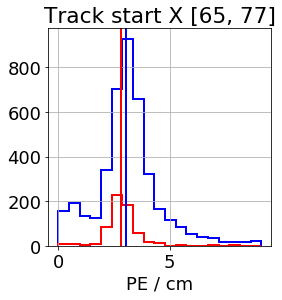

0
converged!
0
converged!


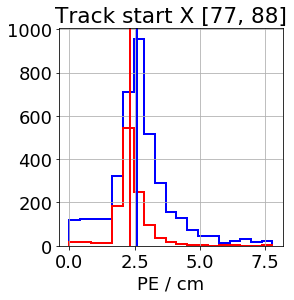

0
converged!
0
converged!


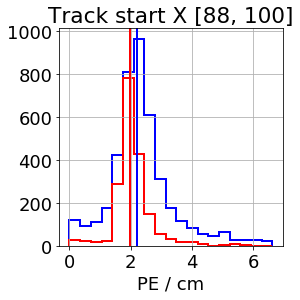

0
converged!
0
converged!


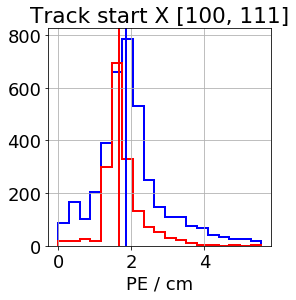

0
converged!
0
converged!


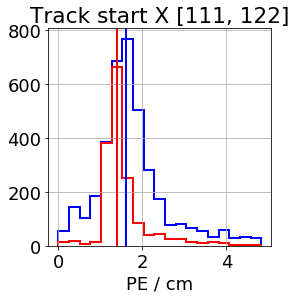

0
converged!
0
converged!


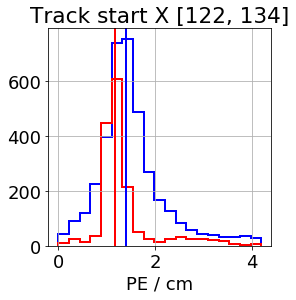

0
converged!
0
converged!


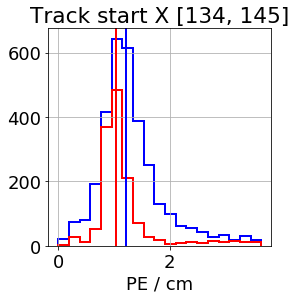

0
converged!
0
converged!


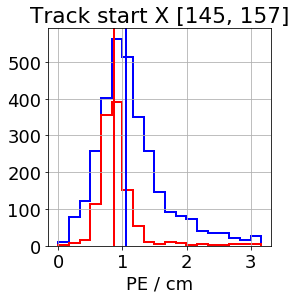

0
1
converged!
0
converged!


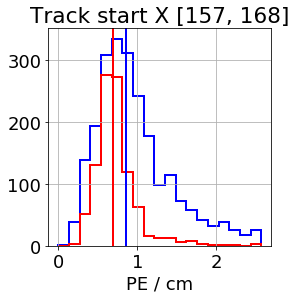

0
1
2
3
converged!
0
converged!


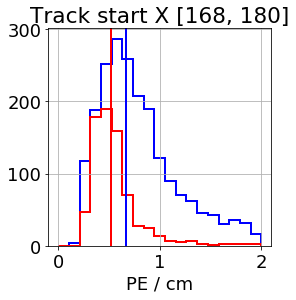

In [18]:
xpos_avg_v,[median_pecm_DF1,error_pecm_DF1],[median_pecm_DF2,error_pecm_DF2],[frac_v,frac_e] = Ratio(dfDATA,dfMCC9,'pecm')
xpos_avg_vg,[median_pecm_DF1g,error_pecm_DF1g],[median_pecm_DF2g,error_pecm_DF2g],[frac_vg,frac_eg] = Ratio(dfDATA,dfMCC9,'pecmg')

0
converged!
0
converged!


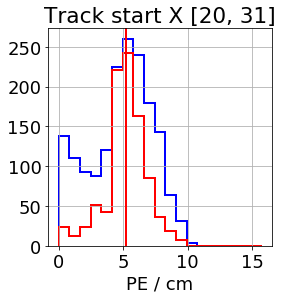

0
converged!
0
converged!


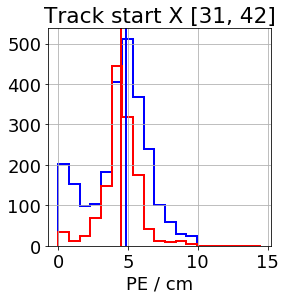

0
converged!
0
converged!


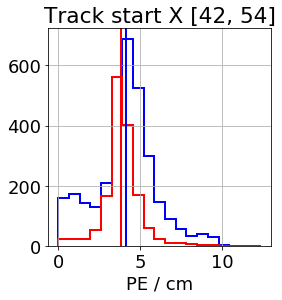

0
converged!
0
converged!


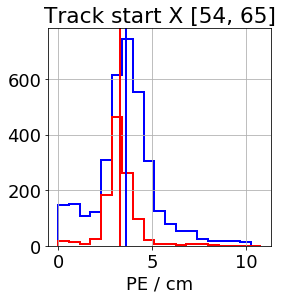

0
converged!
0
converged!


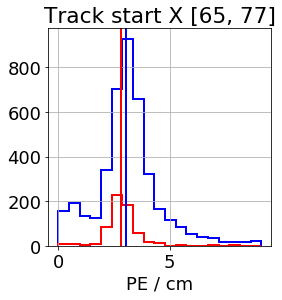

0
converged!
0
converged!


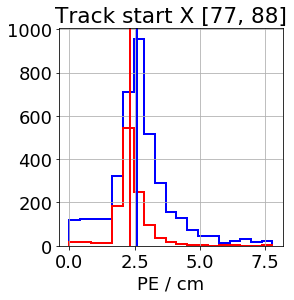

0
converged!
0
converged!


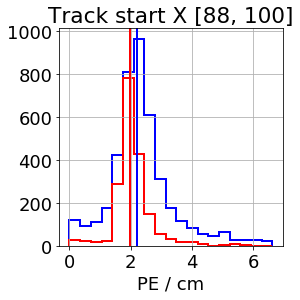

0
converged!
0
converged!


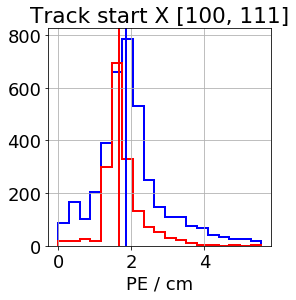

0
converged!
0
converged!


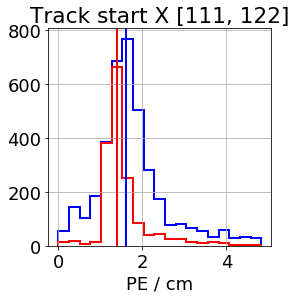

0
converged!
0
converged!


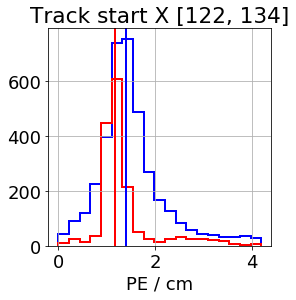

0
converged!
0
converged!


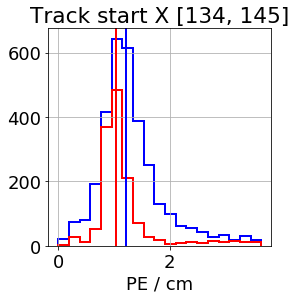

0
converged!
0
converged!


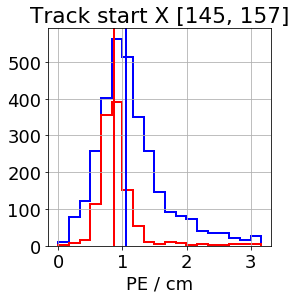

0
1
converged!
0
converged!


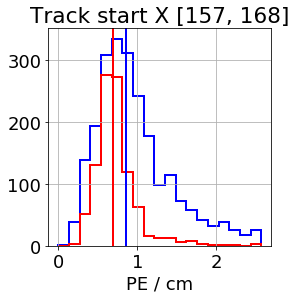

0
1
2
3
converged!
0
converged!


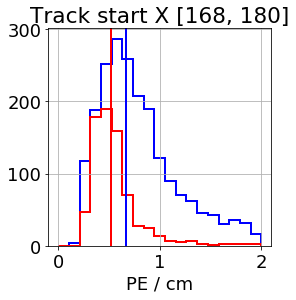

In [19]:
xpos_avg_vg,[median_pecm_DF1g,error_pecm_DF1g],[median_pecm_DF2g,error_pecm_DF2g],[frac_vg,frac_eg] = Ratio(dfDATA,dfMCC9,'pecmg')

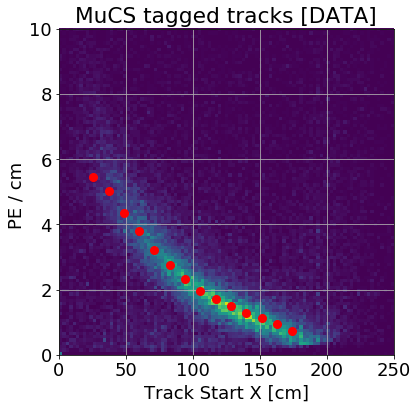

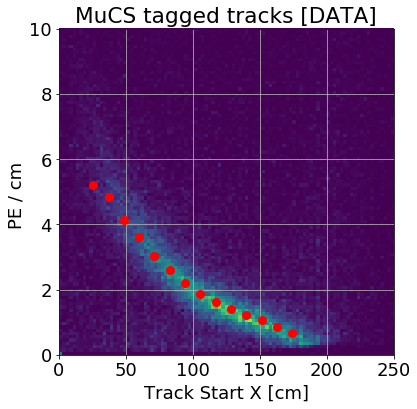

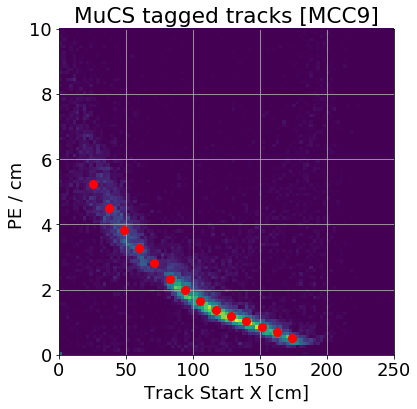

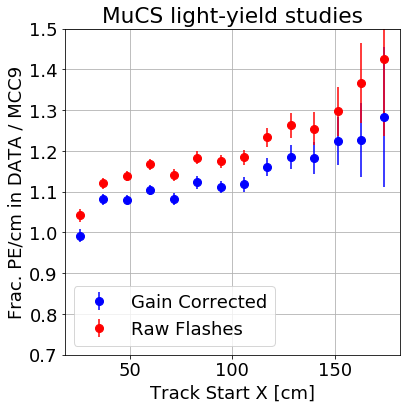

In [20]:
BINSX = np.linspace(0,250,100)
BINSY = np.linspace(0,10,100)


fig = plt.figure(figsize=(6,6))
plt.hist2d(dfDATA['_trk_start_x'].values,dfDATA['pecm'].values,bins=(BINSX,BINSY))
plt.errorbar(xpos_avg_v,median_pecm_DF1,yerr=error_pecm_DF1,fmt='o',color='r',markersize=8)
plt.grid()
plt.xlabel("Track Start X [cm]")
plt.ylabel('PE / cm ')
plt.title("MuCS tagged tracks [DATA]")
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist2d(dfDATA['_trk_start_x'].values,dfDATA['pecmg'].values,bins=(BINSX,BINSY))
plt.errorbar(xpos_avg_vg,median_pecm_DF1g,yerr=error_pecm_DF1g,fmt='o',color='r',markersize=8)
plt.grid()
plt.xlabel("Track Start X [cm]")
plt.ylabel('PE / cm ')
plt.title("MuCS tagged tracks [DATA]")
plt.show()

fig = plt.figure(figsize=(6,6))
plt.hist2d(dfMCC9['_trk_start_x'].values,dfMCC9['pecmg'].values,bins=(BINSX,BINSY))
plt.errorbar(xpos_avg_vg,median_pecm_DF2g,yerr=error_pecm_DF2g,fmt='o',color='r',markersize=8)
plt.grid()
plt.xlabel("Track Start X [cm]")
plt.ylabel('PE / cm ')
plt.title("MuCS tagged tracks [MCC9]")
plt.show()

fig = plt.figure(figsize=(6,6))
plt.errorbar(xpos_avg_vg,frac_vg ,frac_eg ,fmt='o',color='b',markersize=8,label='Gain Corrected')
plt.errorbar(xpos_avg_v,frac_v,frac_e,fmt='o',color='r',markersize=8,label='Raw Flashes')

plt.ylabel('Frac. PE/cm in DATA / MCC9')
plt.xlabel('Track Start X [cm]')
plt.title('MuCS light-yield studies')
plt.ylim([0.7,1.5])
plt.legend(loc=3)
plt.grid()
plt.show()